In [ ]:
!pip install d2l

In [ ]:
# !pip install matplotlib==2.2.3
!pip install timm

In [ ]:
# import torch
# from torch import nn
# from d2l import torch as d2l
# net = nn.Sequential(
#     # 这⾥，我们使⽤⼀个11*11的更⼤窗⼝来捕捉对象。
#     # 同时，步幅为4，以减少输出的⾼度和宽度。
#     # 另外，输出通道的数⽬远⼤于LeNet
#     nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=3, stride=2),
#     # 减⼩卷积窗⼝，使⽤填充为2来使得输⼊与输出的⾼和宽⼀致，且增⼤输出通道数
#     nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=3, stride=2),
#     # 使⽤三个连续的卷积层和较⼩的卷积窗⼝。
#     # 除了最后的卷积层，输出通道的数量进⼀步增加。
#     # 在前两个卷积层之后，汇聚层不⽤于减少输⼊的⾼度和宽度
#     nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
#     nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
#     nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=3, stride=2),
#     nn.Flatten(),
#     # 这⾥，全连接层的输出数量是LeNet中的好⼏倍。使⽤dropout层来减轻过拟合
#     nn.Linear(6400, 4096), nn.ReLU(),nn.Dropout(p=0.5),
#     nn.Linear(4096, 4096), nn.ReLU(),nn.Dropout(p=0.5),
#     # 最后是输出层。由于这⾥使⽤Fashion-MNIST，所以⽤类别数为10，⽽⾮论⽂中的1000
#     nn.Linear(4096, 10))


# X = torch.randn(1, 1, 224, 224)
# for layer in net:
#     X=layer(X)
#     print(layer.__class__.__name__,'output shape:\t',X.shape)


# batch_size = 128
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
# lr, num_epochs = 0.01, 10
# d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# d2l.plt.show()


In [ ]:
import os
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
from d2l import torch as d2l
import time

start = time.perf_counter()

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor()])

def load_data_fashion_mnist(batch_size): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=train_augs, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=test_augs, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

from timm import create_model as creat
model = creat('vit_small_patch16_224', pretrained=True, num_classes=10)
net = nn.Sequential(nn.Conv2d(1,3,kernel_size=1),model)


# 如果param_group=True，输出层中的模型参数将使⽤⼗倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=16, num_epochs=10,
                      param_group=False):
    train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD(
                                [{'params': params_1x},
                               {'params': net.fc.parameters(),
                                'lr': learning_rate * 10}],
                              lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                              weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)
# print(model)
# if hasattr(torch.cuda, 'empty_cache'):
#     torch.cuda.empty_cache()
train_fine_tuning(net, 5e-4)

end = time.perf_counter()
print(end-start)

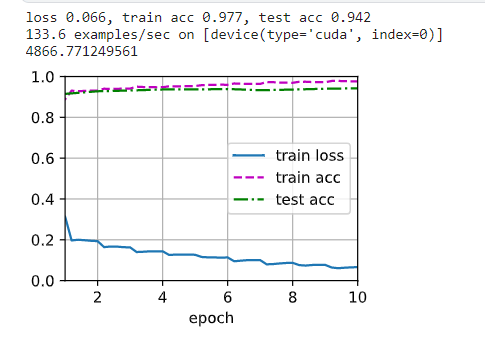